In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from collections import Counter

# Read data, explore target

In [581]:
data = pd.read_excel("220626_chocolate_bar_rating.xlsx")
data.columns = ['ref', 'company_manufacturer', 'company_location', 'review_date',
       'country_of_bean_origin', 'specific_bean_origin_or_bar_name',
       'cocoa_percent', 'ingredients', 'most_memorable_characteristics',
       'rating']
# data = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-18/chocolate.csv")
data

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
1,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
2,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68%,"3- B,S,C","chewy, off, rubbery",3.00
4,2542,5150,U.S.A.,2021,India,"Anamalai, batch 1",68%,"3- B,S,C","milk brownie, macadamia,chewy",3.50
...,...,...,...,...,...,...,...,...,...,...
2583,1205,Zotter,Austria,2014,Blend,Raw,80%,"4- B,S*,C,Sa","waxy, cloying, vegetal",2.75
2584,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75%,"3- B,S,C","strong nutty, marshmallow",3.75
2585,2036,Zotter,Austria,2018,Blend,"Dry Aged, 30 yr Anniversary bar",75%,"3- B,S,C","fatty, earthy, cocoa",3.00
2586,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70%,"3- B,S,C","fatty, mild nuts, mild fruit",3.25


In [61]:
font = {'family' : 'Times New Roman',
        'size'   : 18}
plt.rc('font', **font)

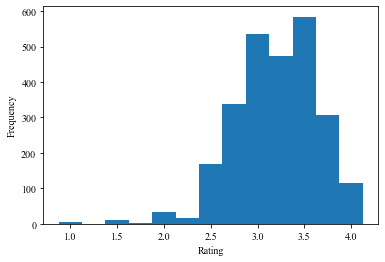

In [4]:
plt.hist(data["rating"], bins=np.arange(0.875, 4.375, 0.25), label="rating")
plt.xticks([1,1.5,2,2.5,3,3.5,4])
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.savefig("figures/ratings_hist.pdf", bbox_inches="tight")
plt.show()

In [5]:
pd.DataFrame(
    {
        "categories": data.loc[
            :,
            [
                "company_manufacturer",
                "company_location",
                "review_date",
                "country_of_bean_origin",
                "specific_bean_origin_or_bar_name",
                "ingredients",
                "most_memorable_characteristics",
            ],
        ].apply(lambda x: len(x.unique())),
        "only occurs once": [
            sum(
                data.loc[
                    :,
                    col,
                ].value_counts()
                == 1
            )
            for col in [
                "company_manufacturer",
                "company_location",
                "review_date",
                "country_of_bean_origin",
                "specific_bean_origin_or_bar_name",
                "ingredients",
                "most_memorable_characteristics",
            ]
        ],
    }
)

,categories,only occurs once
company_manufacturer,593,155
company_location,65,5
review_date,17,0
country_of_bean_origin,63,11
specific_bean_origin_or_bar_name,1643,1423
ingredients,22,3
most_memorable_characteristics,2545,2511


# Data exploration

## Company Manufacturer

In [568]:
manufacturer_shares = data["company_manufacturer"].value_counts()/len(data)
manufacturer_shares#.iloc[0:65,]

Soma                                  0.022025
Fresco                                0.015070
Arete                                 0.012365
Bonnat                                0.011592
A. Morin                              0.011206
                                        ...   
Rococo (Grenada Chocolate Co.)        0.000386
Cacao Arabuco                         0.000386
Britarev                              0.000386
Love Bar                              0.000386
Chocolates by Josh (Box Chocolate)    0.000386
Name: company_manufacturer, Length: 593, dtype: float64

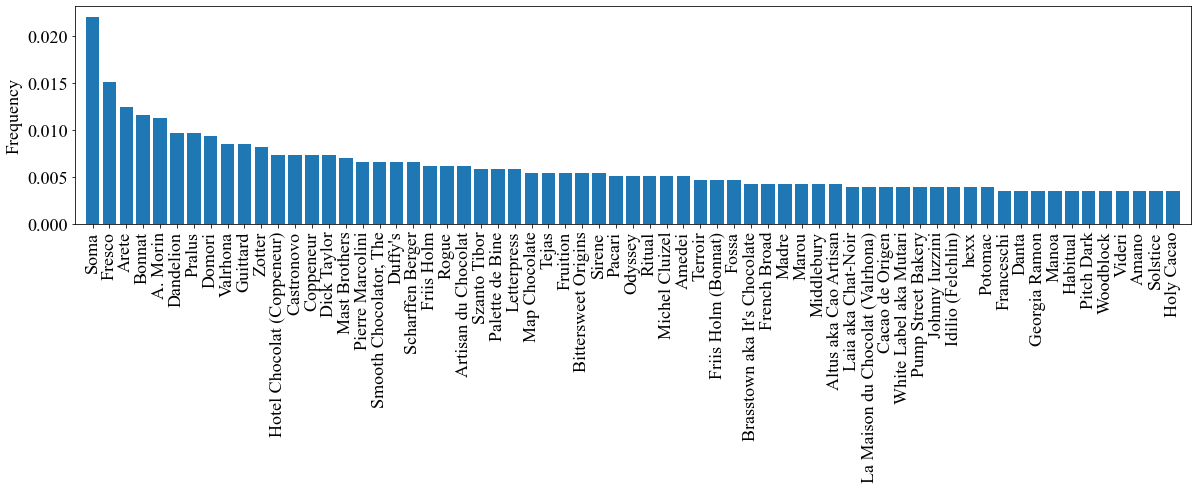

In [569]:
fig, ax = plt.subplots(figsize=(20, 4))
bars = ax.bar(manufacturer_shares.iloc[0:65,].index, manufacturer_shares.iloc[0:65,])

plt.margins(0.01, 0.05)
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.savefig("figures/company_manufacturer_barplot.pdf", bbox_inches="tight")
plt.show()

## Company Location

In [353]:
location_shares = data["company_location"].value_counts()/len(data)
location_shares

U.S.A.                   0.451314
France                   0.069165
Canada                   0.068779
U.K.                     0.051777
Italy                    0.030526
                           ...   
St.Vincent-Grenadines    0.000386
Wales                    0.000386
Martinique               0.000386
Ghana                    0.000386
Suriname                 0.000386
Name: company_location, Length: 65, dtype: float64

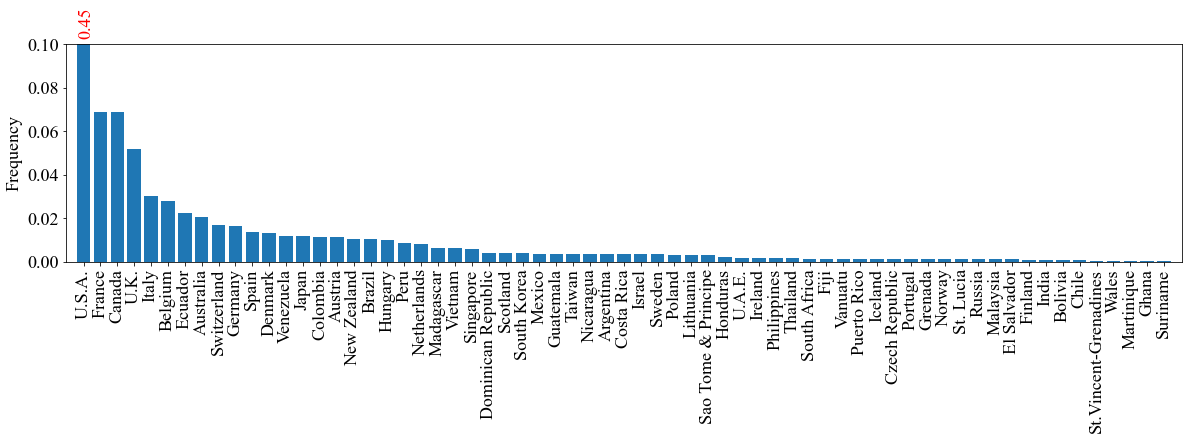

In [570]:
fig, ax = plt.subplots(figsize=(20, 4))
bars = ax.bar(location_shares.index, location_shares)
ax.set_ylim(0, 0.1)

h_usa = f"{round(bars[0].get_height(),2)}"
ax.text(
    bars[0].get_x() + 0.1, 0.11, s=h_usa, ha="left", va="center", rotation=90, c="red"
)

plt.margins(0.01, 0.05)
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.savefig("figures/company_location_barplot.pdf", bbox_inches="tight")
plt.show()

In [448]:
# number of company locations that make up 80% of the observations
len(location_shares.loc[location_shares.cumsum()<=0.8].index)

11

## Review Date

In [549]:
date_freq = data["review_date"].value_counts().sort_index()

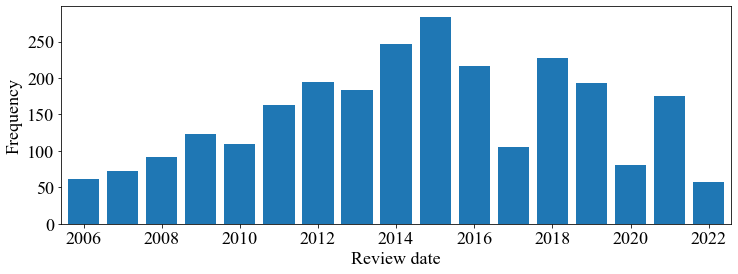

In [556]:
fig, ax = plt.subplots(figsize=(12, 4))
bars = ax.bar(date_freq.index, date_freq)

plt.margins(0.01, 0.05)
plt.xlabel("Review date")
plt.ylabel("Frequency")
plt.show()

## Country of Bean Origin

In [554]:
origin_shares = data["country_of_bean_origin"].value_counts()/len(data)
origin_shares

Venezuela             0.098145
Peru                  0.095827
Dominican Republic    0.090417
Ecuador               0.086167
Madagascar            0.071097
                        ...   
China                 0.000386
Principe              0.000386
Sulawesi              0.000386
Suriname              0.000386
DR Congo              0.000386
Name: country_of_bean_origin, Length: 63, dtype: float64

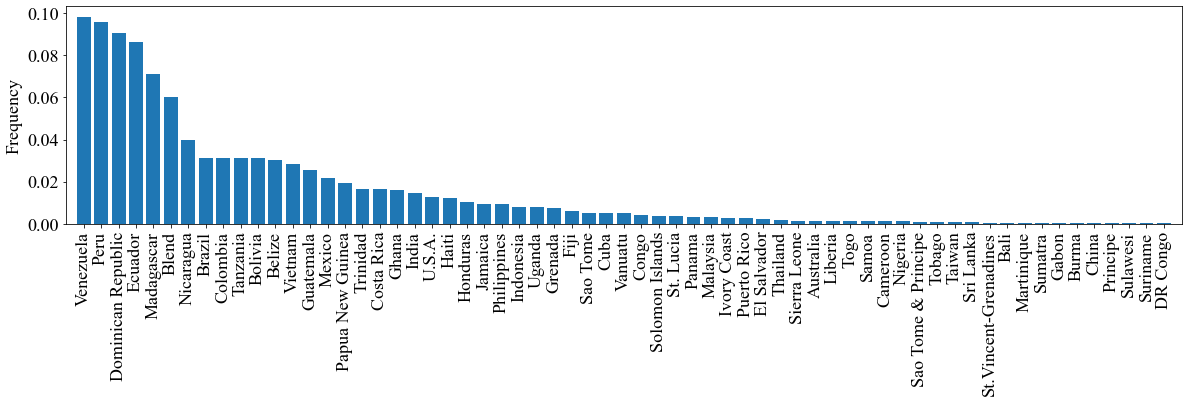

In [571]:
fig, ax = plt.subplots(figsize=(20, 4))
bars = ax.bar(origin_shares.index, origin_shares)

plt.margins(0.01, 0.05)
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.savefig("figures/bean_origin_barplot.pdf", bbox_inches="tight")
plt.show()

## Cocoa Percent

In [585]:
cocoa_percent = data.loc[:,"cocoa_percent"].apply(lambda x: float(x[:-1]))
print(cocoa_percent.min())
print(cocoa_percent.max())

42.0
100.0


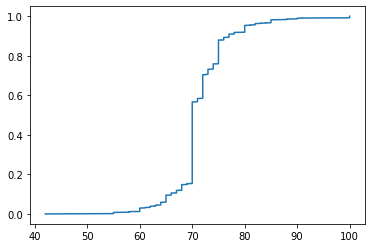

In [27]:
ecdf_percent = ECDF(cocoa_percent)
plt.plot(ecdf_percent.x, ecdf_percent.y)

## Most Memorable Characteristics

In [94]:
data["most_memorable_characteristics"]

0           rich cocoa, fatty, bready
1        cocoa, blackberry, full body
2              cocoa, vegetal, savory
3                 chewy, off, rubbery
4       milk brownie, macadamia,chewy
                    ...              
2583           waxy, cloying, vegetal
2584        strong nutty, marshmallow
2585             fatty, earthy, cocoa
2586     fatty, mild nuts, mild fruit
2587        muted, roasty, accessible
Name: most_memorable_characteristics, Length: 2588, dtype: object

In [95]:
flavours = (
    data["most_memorable_characteristics"]
    .str.replace(" and", ",")
    .str.split(",\s*|\s", expand=True)
)

flavours_list = []
for i in range(5):
    flavours_list.extend(flavours.iloc[:, i].unique())

flavours_set = set(flavours_list)
for s in ["", None]:
    flavours_set.remove(s)

In [96]:
dupes = [x for x in flavours_list if not x in ["", None]]
for i in range(6):
    print("occur >= "+ str(i+1) + "x:", len(set(dupes)))
    seen = set()
    dupes = [x for x in dupes if x in seen or seen.add(x)]
    if i == 3:
        print(dupes)

occur >= 1x: 578
occur >= 2x: 308
occur >= 3x: 218
occur >= 4x: 135
['fatty', 'nutty', 'fruit', 'banana', 'earthy', 'sandy', 'sour', 'rubber', 'roasty', 'musty', 'cocoa', 'mint', 'creamy', 'notes', 'tart', 'vanilla', 'leather', 'coffee', 'roast', 'brownie', 'anise', 'sweet', 'off', 'berry', 'base', 'dried', 'sticky', 'floral', 'butter', 'licorice', 'nuts', 'burnt', 'spice', 'citrus', 'woody', 'molasses', 'strawberry', 'melon', 'nut', 'intense', 'rich', 'orange', 'choco', 'rubbery', 'lemon', 'smoke', 'ashey', 'harsh', 'spicy', 'grits', 'bitter', 'grassy', 'vegetal']
occur >= 5x: 53
occur >= 6x: 0


In [129]:
flavours_df = pd.Series(flavours_list).dropna()
flavours_df[flavours_df.str.contains("nut")].unique()

array(['nutty', 'nut', 'nuts', 'nutmeg', 'hazelnut', 'peanut', 'coconut',
       'cocounut', 'walnut', 'walnuts', 'peanutbutter', 'nutella'],
      dtype=object)

In [130]:
flavours_df = pd.Series(flavours_list).dropna()
flavours_df[flavours_df.str.contains("choc")].unique()

array(['chocolate', 'choco', 'chocolatey', 'chocolaty'], dtype=object)

### Autocorrect

In [31]:
from autocorrect import Speller
from spellchecker import SpellChecker

In [32]:
spell = Speller()
for f in flavours_set:
    f_corr = spell(f)
    if f != f_corr:
        print(f, "->", f_corr)

earthy -> earth
descript -> script
watery -> water
pungent -> urgent
leathery -> leather
alkalyzed -> analyzed
fudge -> judge
roaste -> roasted
chalky -> chalk
clove -> close
sliglty -> slightly
musty -> must
Roasty -> Roast
winey -> wine
unfixable -> fixable
crunchy -> crunch
waxy -> way
tangy -> tango
alocohol -> alcohol
papaya -> papal
AT -> A
Fruity -> Fruit
macadamia -> academia
nutmeg -> nummer
punchy -> punch
chocolaty -> chocolate
carame -> came
raisns -> raises
petro -> metro
pasty -> party
sugary -> sugar
nibs -> nis
sligthly -> slightly
alluring -> alluding
smokey -> smoke
unrefined -> undefined
oreo -> ordo
nutty -> duty
licoric -> iconic
walnuts -> walnut
chewy -> chew
unripe -> unlike
astingent -> stringent
overyly -> overly
cheesy -> cheese
spicey -> spices
fudgey -> budget
vanila -> manila
non-descript -> non-script
Hammy -> Army
meaty -> meat
prononced -> pronounced
roasty/smokey -> roast/smoke
hebs -> hubs
earty -> party
spiciness -> sickness
brownie -> browne
sandpap

In [33]:
spell = SpellChecker()
for f in flavours_set:
    f_corr = spell.correction(f)
    if f != f_corr:
        print(f, "->", f_corr)

mouthfeel -> mouthful
descript -> describe
alkalyzed -> analyzed
roaste -> roast
sliglty -> slighty
Roasty -> roast
winey -> wine
unfixable -> unlikable
alocohol -> alcohol
dirt/ -> dirty
astringcy -> stringy
carame -> caramel
"Andes" -> andes
(fig) -> fig
raisns -> rains
sl. -> sly
ham-like -> hairlike
sl -> so
sligthly -> slightly
licoric -> licorice
astingent -> astringent
overyly -> overly
spicey -> spice
vanila -> vanilla
non-descript -> nondescript
prononced -> pronounced
hebs -> he's
earty -> party
astringency -> stringency
molassses -> molasses
cheesey -> cheese
cardamon -> cardamom
roasty -> roast
ligt -> light
rasin -> rain
smomkey -> smokey
nibby -> dibby
mildy -> mild
klingy -> clingy
XL -> al
pomegrant -> pomegranate
cocounut -> coconut
cinamon -> cinnamon
"rolo" -> prolon
pastey -> pastry
dutched? -> ditched
sticy -> stick
lavendar -> lavender
malitol -> marital
fertilzer -> fertilizer
accesible -> accessible
brownine -> brownie
blackcherry -> blackberry
smoth -> smooth
d

In [34]:
spell.unknown(flavours_set)

{'"andes"',
 '"rolo"',
 '(fig)',
 'accesible',
 'aftertaste',
 'alkalyzed',
 'alocohol',
 'ashey',
 'astingent',
 'astringcy',
 'astringency',
 'astringnet',
 'blackcherry',
 'blackpepper',
 'bready',
 'brownine',
 'cadbury',
 'candy-like',
 'carame',
 'cardamon',
 'cheesey',
 'cinamon',
 'cocounut',
 'cooa',
 'descript',
 'dirt/',
 'dirty/burnt',
 'distinquished',
 'domintates',
 'dutched?',
 'earty',
 'fertilzer',
 'floral-spice',
 'fudge-like',
 'ham-like',
 'hebs',
 'intens',
 'klingy',
 'lavendar',
 'licoric',
 'ligt',
 'malitol',
 'mildy',
 'molassses',
 'mouthfeel',
 'nibby',
 'non-descript',
 'overyly',
 'pastey',
 'peanutbutter',
 'pomegrant',
 'prononced',
 'raisiny',
 'raisns',
 'rasin',
 'roaste',
 'roasty',
 'roasty/smokey',
 'sl',
 'sl.',
 'sliglty',
 'sligt',
 'sligthly',
 'smomkey',
 'smoth',
 'spciy',
 'spice/herb',
 'spicey',
 'sticy',
 'sublte',
 'tea-like',
 'trop.',
 'unfixable',
 'vanila',
 'vanilla(n)',
 'w/',
 'winey',
 'woody/green',
 'wtf',
 'xl'}

In [35]:
from textblob import Word

In [36]:
#for f in flavours_set:
#    word = Word(f)
#    print(f)
#    print(word.spellcheck())

medley
[('merely', 0.9043062200956937), ('madly', 0.03349282296650718), ('meddle', 0.028708133971291867), ('motley', 0.014354066985645933), ('morley', 0.004784688995215311), ('mele', 0.004784688995215311), ('meddler', 0.004784688995215311), ('eley', 0.004784688995215311)]
mouthfeel
[('mouthfeel', 0.0)]
ending
[('ending', 1.0)]
floral
[('flora', 1.0)]
uncontrolled
[('uncontrolled', 1.0)]
is
[('is', 1.0)]
walnut
[('walnut', 1.0)]
dirty/burnt
[('dirty/burnt', 0.0)]
leather
[('leather', 1.0)]
earthy
[('earthy', 1.0)]
descript
[('rescript', 1.0)]
watery
[('watery', 1.0)]
pungent
[('pungent', 1.0)]
acidity
[('aridity', 1.0)]
well
[('well', 1.0)]
atypical
[('typical', 1.0)]
slow
[('slow', 1.0)]
oranges
[('oranges', 1.0)]
multiple
[('multiple', 1.0)]
some
[('some', 1.0)]
brown
[('brown', 1.0)]
leathery
[('leathery', 1.0)]
ripe
[('ripe', 1.0)]
alkalyzed
[('analyzed', 1.0)]
fudge
[('judge', 0.9375), ('budge', 0.0625)]
butt
[('butt', 1.0)]
roaste
[('roast', 0.8), ('roasted', 0.2)]
mild
[('mild', 

[('Fruit', 0.2702702702702703), ('Purity', 0.24324324324324326), ('Fruits', 0.1891891891891892), ('Bruit', 0.13513513513513514), ('Rusty', 0.05405405405405406), ('Equity', 0.05405405405405406), ('Trusty', 0.04054054054054054), ('Crusty', 0.013513513513513514)]
herbal
[('verbal', 1.0)]
residue
[('residue', 1.0)]
baked
[('baked', 1.0)]
mix
[('mix', 1.0)]
basic
[('basic', 1.0)]
metal
[('metal', 1.0)]
cacao
[('canal', 0.7422680412371134), ('sacro', 0.05154639175257732), ('cargo', 0.05154639175257732), ('cava', 0.030927835051546393), ('facto', 0.020618556701030927), ('carlo', 0.020618556701030927), ('cameo', 0.020618556701030927), ('cabal', 0.020618556701030927), ('cocoa', 0.010309278350515464), ('cavae', 0.010309278350515464), ('campo', 0.010309278350515464), ('cairo', 0.010309278350515464)]
gateway
[('gateway', 1.0)]
pistachio
[('pistachio', 0.0)]
bar
[('bar', 1.0)]
fat
[('fat', 1.0)]
macadamia
[('macadamia', 0.0)]
nutmeg
[('nutmeg', 0.0)]
off
[('off', 1.0)]
true
[('true', 1.0)]
punchy
[(

KeyboardInterrupt: 

### Word stemming

In [132]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

In [38]:
ps = nltk.stem.SnowballStemmer("english")

In [39]:
for f in flavours_set:
    f_stem = ps.stem(f)
    if f != f_stem:
        print(f, "->", f_stem)

ending -> end
uncontrolled -> uncontrol
earthy -> earthi
watery -> wateri
acidity -> acid
atypical -> atyp
oranges -> orang
multiple -> multipl
leathery -> leatheri
alkalyzed -> alkalyz
fudge -> fudg
roaste -> roast
berry -> berri
chalky -> chalki
sliglty -> sliglti
very -> veri
musty -> musti
Fruit -> fruit
Roasty -> roasti
evolves -> evolv
unfixable -> unfix
perfectly -> perfect
crunchy -> crunchi
gentle -> gentl
waxy -> waxi
olive -> oliv
candy -> candi
tangy -> tangi
defined -> defin
strawberries -> strawberri
astringcy -> astringci
notes -> note
smokiness -> smoki
AT -> at
mildly -> mild
Fruity -> fruiti
residue -> residu
baked -> bake
punchy -> punchi
chocolaty -> chocolati
carame -> caram
"Andes" -> "andes"
grounds -> ground
unbalanced -> unbalanc
dry -> dri
raisns -> raisn
body -> bodi
spicy -> spici
issues -> issu
ambiguous -> ambigu
early -> earli
edge -> edg
peanutbutter -> peanutbutt
pasty -> pasti
cooked -> cook
muddy -> muddi
heavy -> heavi
medicine -> medicin
sugary -> s

In [133]:
for f in flavours_set:
    f_changed = WordNetLemmatizer().lemmatize(f)
    if f != f_changed:
        print(f)
        print(WordNetLemmatizer().lemmatize(f))

oats
oat
fades
fade
flavors
flavor
raspberries
raspberry
undertones
undertone
spices
spice
hints
hint
ends
end
walnuts
walnut
strawberries
strawberry
prunes
prune
issues
issue
blackberries
blackberry
molassses
mola
grits
grit
plums
plum
raisins
raisin
oranges
orange
grapes
grape
herbs
herb
less
le
dates
date
nibs
nib
grounds
ground
blueberries
blueberry
nuts
nut
berries
berry
lacks
lack
cranberries
cranberry
pieces
piece
notes
note
carrots
carrot
cherries
cherry


# Methods for Evaluation

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

In [6]:
def mdae(y_true, y_pred):
    return abs(y_true - y_pred).median()

In [7]:
def print_scores(m, X_train, X_test):
    y_pred_train = m.predict(X_train)
    y_pred = m.predict(X_test)

    # regression
    # print(
    #    "R^2:\t\t",
    #    "Train: {0:0.4f}".format(m.score(X_train, y_train)),
    #    ", Valid: {0:0.4f}".format(m.score(X_test, y_test)),
    # )
    print(
        "MSE:\t\t",
        "Train: {0:0.4f}".format(mse(y_pred_train, y_train)),
        "\tTest: {0:0.4f}".format(mse(y_pred, y_test)),
    )
    print(
        "MdAE:\t\t",
        "Train: {0:0.4f}".format(mdae(y_pred_train, y_train)),
        "\tTest: {0:0.4f}".format(mdae(y_pred, y_test)),
    )

    # classification:
    targets = np.arange(1, 4, 0.25)
    diff = np.subtract.outer(
        y_pred_train, targets
    )  # substract all targets from each prediction
    i = np.argmin(abs(diff), axis=1)  # closest indices of target to prediction
    y_pred_train_cat = targets[i].astype(str)
    diff = np.subtract.outer(y_pred, targets)
    i = np.argmin(abs(diff), axis=1)
    y_pred_cat = targets[i].astype(str)

    print(
        "Accuracy:\t",
        "Train: {0:0.4f}".format(accuracy_score(y_train_cat, y_pred_train_cat)),
        "\tTest: {0:0.4f}".format(accuracy_score(y_test_cat, y_pred_cat)),
    )

In [8]:
def print_scores_classification(m, X_train, X_test):
    y_pred_train = m.predict(X_train)
    y_pred = m.predict(X_test)

    print(
        "Accuracy:\t",
        "Train: {0:0.4f}".format(accuracy_score(y_train_cat, y_pred_train)),
        "\tTest: {0:0.4f}".format(accuracy_score(y_test_cat, y_pred)),
    )

In [9]:
def histogram_residuals(y_test, y_pred, model_name="some_model"):
    residuals = y_test - y_pred
    plt.hist(residuals, bins=np.arange(-2.125, 1.125, 0.25))
    plt.xticks(np.arange(-2, 1.25, 0.5))
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.savefig(f"figures/residuals_{model_name}_hist.pdf", bbox_inches="tight")
    plt.show()

# Pre-processing and splitting

## Pre-processing before train test split

In [53]:
# make cocoa_percent numeric
data.loc[:,"cocoa_percent"] = data.loc[:,"cocoa_percent"].apply(lambda x: float(x[:-1]))/100

In [55]:
print("Missing ingredients:\t", data["ingredients"].isnull().sum())
print(
    "with cocoa percent = 1:\t",
    len(
        data.loc[
            data["ingredients"].isnull() & (data["cocoa_percent"] == 1),
            "ingredients",
        ]
    ),
)

Missing ingredients:	 87
with cocoa percent = 1:	 14


In [56]:
# replace nan ingredients
data.loc[
    data["ingredients"].isnull() & (data["cocoa_percent"] == 1),
    "ingredients",
] = "1- B"

In [57]:
# get number of ingredients
ingredients = (
    data["ingredients"]
    .str.split("-\s*", expand=True)
)
ingredients.columns = ["number_ingredients", "ingredients"]
data.loc[:,"number_ingredients"] = pd.to_numeric(ingredients.iloc[:,0], errors='coerce')
data.loc[:,"ingredients"] = ingredients["ingredients"]

In [59]:
h=data["ingredients"].value_counts()
x=h.index
h

B,S,C           1029
B,S              738
B,S,C,L          293
B,S,C,V,L        184
B,S,C,V          141
B,S*              31
B,S*,C,Sa         20
B                 20
B,S*,C            13
B,S,L              8
B,S*,C,V           7
B,S,C,V,Sa         6
B,S,V,L            5
B,S,C,Sa           5
B,S,C,V,L,Sa       4
B,S,V              3
B,S*,V,L           3
B,S*,C,L           2
B,S*,Sa            1
B,C                1
B,S,C,L,Sa         1
Name: ingredients, dtype: int64

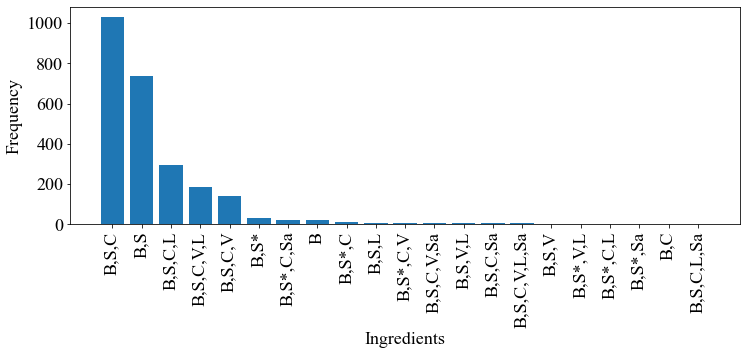

In [62]:
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(x, h)
plt.xticks(rotation=90)
plt.xlabel("Ingredients")
plt.ylabel("Frequency")
plt.savefig("figures/ingredients_barplot.pdf", bbox_inches="tight")
plt.show()

## Train test split

In [63]:
from sklearn.model_selection import train_test_split

In [131]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    data.loc[:, data.columns != "rating"], data["rating"], test_size=0.15, random_state=1
)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_train_raw, y_train, test_size=0.15, random_state=1
)
y_train_cat = y_train.astype(str)
y_val_cat = y_val.astype(str)
y_test_cat = y_test.astype(str)

In [132]:
print(X_train_raw.shape)
print(y_train.shape)
print(X_val_raw.shape)
print(y_val.shape)
print(X_test_raw.shape)
print(y_test.shape)

(1869, 10)
(1869,)
(330, 10)
(330,)
(389, 10)
(389,)


## Pre-processing after train test split

In [133]:
# fill nan number_ingredients with median
median = X_train_raw.loc[
    (~X_train_raw["number_ingredients"].isnull()) & (X_train_raw["cocoa_percent"] < 1),
    "number_ingredients",
].median()
print(median)

X_train_raw.loc[
    X_train_raw["number_ingredients"].isnull(),
    "number_ingredients",
] = median
X_val_raw.loc[
    X_val_raw["number_ingredients"].isnull(),
    "number_ingredients",
] = median
X_test_raw.loc[
    X_test_raw["number_ingredients"].isnull(),
    "number_ingredients",
] = median

3.0


In [134]:
X_train_raw

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,number_ingredients
1439,1395,Lonohana,U.S.A.,2014,U.S.A.,"O'ahu Island, Haleiwa E, 2014",0.75,"B,S,C,V","dairy, pudding",4.0
1833,1415,Pacari,Ecuador,2014,Ecuador,Cumbia,0.70,"B,S,C,L","savory, smokey",4.0
170,600,Artisan du Chocolat,U.K.,2010,Vietnam,Ba Ria Vung Tau Province,0.72,"B,S,C","unrefined, distinct spicey",3.0
2461,2744,Vesta,U.S.A.,2022,Guatemala,Guatemala,0.78,"B,S*,C","rich cocoa, fruit, bitter, molasses",3.0
1308,241,Kallari (Ecuatoriana),Ecuador,2008,Ecuador,Sisa 36hr/ W. F. blend prototype,0.70,"B,S,C,V","creamy, mild marshmallow",4.0
...,...,...,...,...,...,...,...,...,...,...
2530,1042,Woodblock,U.S.A.,2013,Trinidad,"Gran Couva, batch 1",0.70,"B,S","creamy, woody, mild metallic",2.0
44,2438,Aelan,Vanuatu,2019,Vanuatu,"Malekula Island, batch M10/19",0.70,"B,S","unrefined, sweet, metallic",2.0
1930,2622,Potomac,U.S.A.,2021,Peru,"Ucayali, batch 200105",0.70,"B,S","anise, cocoa, dried fruit",2.0
1247,725,Idilio (Felchlin),Switzerland,2011,Venezuela,Coopertiva Amazona,0.72,"B,S,C","creamy, cocoa, lemon",3.0


# Feature Engineering

In [135]:
X_train = X_train_raw.copy()
X_val = X_val_raw.copy()
X_test = X_test_raw.copy()

In [136]:
features_dict = {
    "baseline": ["cocoa_percent", "number_ingredients"],
    "one_hot_encoded": {
        "company_manufacturer": [],
        "company_location": [],
        "country_of_bean_origin": [],
    },
    "target_encoded": {
        "company_manufacturer": [],
        "company_location": [],
        "country_of_bean_origin": [],
    },
    "ingredients": [],
    "most_memorable_characteristics": [],
}

## Review Date

In [137]:
dates = X_train_raw["review_date"].unique()
dates.sort()

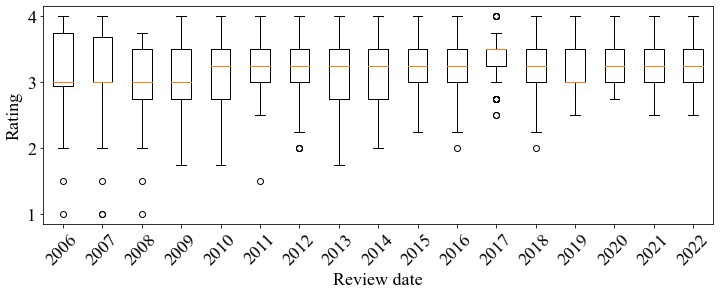

In [138]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.boxplot([y_train[X_train_raw["review_date"] == rd] for rd in dates], labels=dates)
plt.xticks(rotation=45)
plt.xlabel("Review date")
plt.ylabel("Rating")
plt.savefig("figures/review_date_boxplot.pdf", bbox_inches="tight")
plt.show()

In [139]:
# label encoding
min_date = X_train["review_date"].min()
X_train.loc[:,"review_date"] = X_train_raw.loc[:,"review_date"] - min_date
X_val.loc[:,"review_date"] = X_val_raw.loc[:,"review_date"] - min_date
X_test.loc[:,"review_date"] = X_test_raw.loc[:,"review_date"] - min_date
X_val.loc[:,"review_date"].unique()

array([ 9,  6,  3, 12, 13,  2,  8,  1, 16,  4,  5, 10, 11,  7, 15, 14,  0],
      dtype=int64)

In [140]:
X_train["review_date"].corr(y_train)

0.11431817568054758

In [141]:
from sklearn.linear_model import LinearRegression

In [230]:
lm = LinearRegression()
lm.fit(np.array(X_train["review_date"]).reshape(-1, 1), y_train)
print("intercept:\t", round(lm.intercept_, 4))
print("coefficient:\t", round(lm.coef_[0], 4))

intercept:	 3.0984
coefficient:	 0.0124


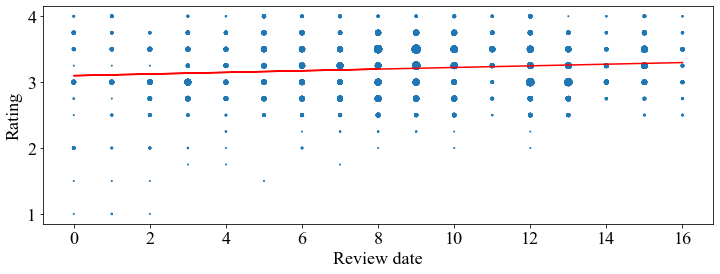

In [221]:
x = X_train["review_date"]

c = Counter(zip(x, y_train))
s = [c[(n, r)] for n, r in zip(x, y_train)]

plt.subplots(figsize=(12, 4))
plt.scatter(x, y_train, marker="o", s=s)
plt.plot(x, lm.coef_ * x + lm.intercept_, color="red")
plt.xlabel("Review date")
plt.ylabel("Rating")
plt.savefig("figures/review_date_points.pdf", bbox_inches="tight")
plt.show()

In [216]:
from statsmodels.api import OLS, add_constant
from statsmodels.stats.diagnostic import het_white

In [263]:
x = add_constant(np.array(X_train["review_date"]))
res = OLS(y_train, x).fit()

In [274]:
white_test = het_white(res.resid,  res.model.exog)
print("LM-Test p-value:", white_test[1]) # << 0.05

LM-Test p-value: 2.13056964313503e-22


In [341]:
x = np.array(X_train["review_date"].apply(lambda x: x^2))
print("correlation with rating:", pd.Series(x).corr(y_train))
X = add_constant(x)
res = OLS(y_train, X).fit()
white_test = het_white(res.resid,  res.model.exog)
print("LM-Test p-value:\t", white_test[1]) # << 0.05

correlation with rating: 0.023106962375003173
LM-Test p-value:	 1.3600569063787788e-12


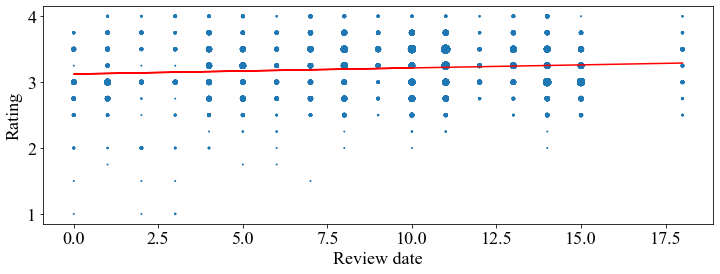

In [342]:
c = Counter(zip(x, y_train))
s = [c[(n, r)] for n, r in zip(x, y_train)]

plt.subplots(figsize=(12, 4))
plt.scatter(x, y_train, marker="o", s=s)
plt.plot(x, res.params.x1 * x + res.params.const, color="red")
plt.xlabel("Review date")
plt.ylabel("Rating")
#plt.savefig("figures/review_date_points.pdf", bbox_inches="tight")
plt.show()

In [343]:
x = X_train["review_date"]
y = y_train.apply(math.log)
print("correlation with rating:", x.corr(y))
X = add_constant(x)
res = OLS(y, X).fit()
white_test = het_white(res.resid,  res.model.exog)
print("LM-Test p-value:\t", white_test[1]) # << 0.05

correlation with rating: 0.13730101617599713
LM-Test p-value:	 1.968918067731626e-19


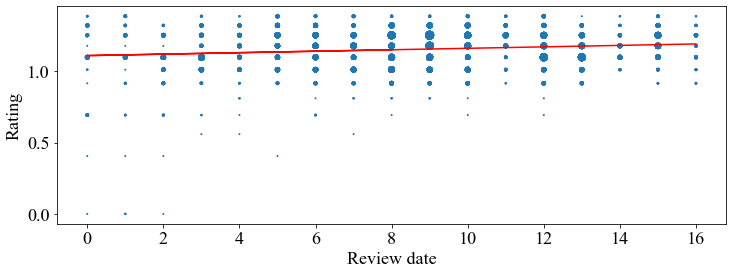

In [346]:
c = Counter(zip(x, y))
s = [c[(n, r)] for n, r in zip(x, y)]

plt.subplots(figsize=(12, 4))
plt.scatter(x, y, marker="o", s=s)
plt.plot(x, res.params.review_date * x + res.params.const, color="red")
plt.xlabel("Review date")
plt.ylabel("Rating")
#plt.savefig("figures/review_date_points.pdf", bbox_inches="tight")
plt.show()

In [144]:
features_dict["baseline"] += ["review_date"]
features_dict

{'baseline': ['cocoa_percent', 'number_ingredients', 'review_date'],
 'one_hot_encoded': {'company_manufacturer': [],
  'company_location': [],
  'country_of_bean_origin': []},
 'target_encoded': {'company_manufacturer': [],
  'company_location': [],
  'country_of_bean_origin': []},
 'ingredients': [],
 'most_memorable_characteristics': []}

## Features with many categories

In [542]:
locations_counts = X_train["company_location"].value_counts()
locations = locations_counts.loc[locations_counts >= 25].index

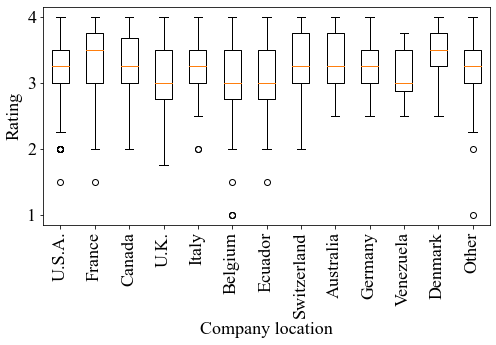

In [547]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.boxplot(
    [y_train[X_train["company_location"] == loc] for loc in locations],
    labels=locations,
    widths=0.5,
)
ax.boxplot(
    y_train[~X_train["company_location"].isin(locations)],
    positions=[len(locations) + 1],
    labels=["Other"],
    widths=0.5,
)

plt.xticks(rotation=90)
plt.xlabel("Company location")
plt.ylabel("Rating")
plt.savefig("figures/company_location_boxplot.pdf", bbox_inches="tight")
plt.show()

In [145]:
from category_encoders import OneHotEncoder, TargetEncoder

In [146]:
def apply_encoding(col_name, crit_value):
    # compute the number of observations per category
    counts = X_train_raw[col_name].value_counts()

    # find large enough categories
    categories = counts[counts > crit_share].index

    # create column where small categories are aggregated as "other"
    col_agg = col_name + "_agg"
    X_train_raw[col_agg] = X_train_raw[col_name]
    X_train_raw.loc[~X_train_raw[col_agg].isin(categories), col_agg] = "other"
    X_val_raw[col_agg] = X_val_raw[col_name]
    X_val_raw.loc[~X_val_raw[col_agg].isin(categories), col_agg] = "other"
    X_test_raw[col_agg] = X_test_raw[col_name]
    X_test_raw.loc[~X_test_raw[col_agg].isin(categories), col_agg] = "other"
    
    # one hot encoding
    encoder_oh = OneHotEncoder(cols=col_agg, use_cat_names=True)
    encoded_oh_train = encoder_oh.fit_transform(X_train_raw, y_train)
    encoded_oh_val = encoder_oh.transform(X_val_raw)
    encoded_oh_test = encoder_oh.transform(X_test_raw)    
    cols_enc_oh = [
        name
        for name in filter(
            lambda x: x.startswith(col_agg) & ~x.endswith("other"), encoded_oh_train.columns
        )
    ]
    X_train[cols_enc_oh] = encoded_oh_train[cols_enc_oh]
    X_val[cols_enc_oh] = encoded_oh_val[cols_enc_oh]
    X_test[cols_enc_oh] = encoded_oh_test[cols_enc_oh]
    features_dict["one_hot_encoded"][col_name] = cols_enc_oh

    # target encoding
    encoder_t = TargetEncoder(
        cols=col_name, handle_unknown="value", min_samples_leaf=20, smoothing=10
    )
    encoded_t_train = encoder_t.fit_transform(X_train_raw, y_train)
    encoded_t_val = encoder_t.transform(X_val_raw)
    encoded_t_test = encoder_t.transform(X_test_raw)
    X_train[col_name + "_encoded_t"] = encoded_t_train[col_name]
    X_val[col_name + "_encoded_t"] = encoded_t_val[col_name]
    X_test[col_name + "_encoded_t"] = encoded_t_test[col_name]
    features_dict["target_encoded"][col_name] = col_name + "_encoded_t"

In [147]:
apply_encoding("company_manufacturer", crit_share=25)
apply_encoding("company_location", crit_share=25)
apply_encoding("country_of_bean_origin", crit_share=50)

In [573]:
# percentage of observations where company location and country of bean origin coincide
len(X_train.loc[X_train["company_location"] == X_train["country_of_bean_origin"],]) / len(X_train)

0.12627073301230604

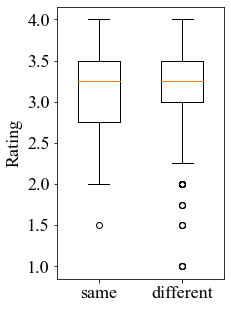

In [575]:
fig, ax = plt.subplots(figsize=(3, 5))

ax.boxplot(
    y_train[X_train["company_location"] == X_train["country_of_bean_origin"]],
    positions=[0],
    labels=["same"],
    widths=0.5,
)
ax.boxplot(
    y_train[X_train["company_location"] != X_train["country_of_bean_origin"]],
    positions=[1],
    labels=["different"],
    widths=0.5,
)

plt.ylabel("Rating")
plt.savefig("figures/location_vs_bean_origin.pdf", bbox_inches="tight")
plt.show()

## Ingredients

In [171]:
index_missing_train = X_train_raw.loc[X_train_raw["ingredients"].isnull(),].index
index_missing_val = X_val_raw.loc[X_val_raw["ingredients"].isnull(),].index
index_missing_test = X_test_raw.loc[X_test_raw["ingredients"].isnull(),].index
len(index_missing_test) + len(index_missing_val) + len(index_missing_train)

73

In [172]:
ingredients_list = ["sugar", "sweetener", "cocoa_butter", "vanilla", "lecithin", "salt"]
ingredients_abbrev = ["S,", "S\*", "C", "V", "L", "Sa"]

In [173]:
ingredients_df_train = pd.DataFrame(columns=ingredients_list)
ingredients_df_val = ingredients_df_train.copy()
ingredients_df_test = ingredients_df_train.copy()

for i, a in enumerate(ingredients_abbrev):
    ingredients_df_train.loc[:, ingredients_list[i]] = X_train_raw["ingredients"].str.contains(a, na=False)
    ingredients_df_val.loc[:, ingredients_list[i]] = X_val_raw["ingredients"].str.contains(a, na=False)
    ingredients_df_test.loc[:, ingredients_list[i]] = X_test_raw["ingredients"].str.contains(a, na=False)

In [174]:
# sugar is abbreviated with "S," in the list above to avoid confusion with sweetener (S*)
# need to account for ingredients ending with "S" and thus having no "," in the end
ingredients_df_train.loc[:, "sugar"] = ingredients_df_train.loc[:, "sugar"] | X_train_raw["ingredients"].str.endswith("S")
ingredients_df_val.loc[:, "sugar"] = ingredients_df_val.loc[:, "sugar"] | X_val_raw["ingredients"].str.endswith("S")
ingredients_df_test.loc[:, "sugar"] = ingredients_df_test.loc[:, "sugar"] | X_test_raw["ingredients"].str.endswith("S")

In [175]:
X_train[ingredients_list] = ingredients_df_train.astype(int)
X_val[ingredients_list] = ingredients_df_val.astype(int)
X_test[ingredients_list] = ingredients_df_test.astype(int)

In [176]:
features_dict["ingredients"] = ingredients_list

In [177]:
h=X_train[features_dict["ingredients"]].mean().sort_values(ascending=False)
h

sugar           0.932049
cocoa_butter    0.663456
lecithin        0.199572
vanilla         0.134296
sweetener       0.030498
salt            0.013376
dtype: float64

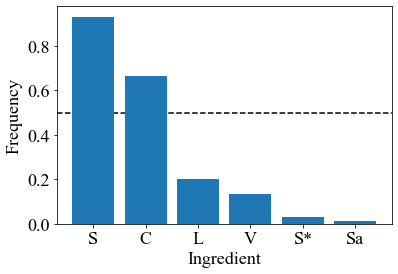

In [178]:
plt.bar(["S", "C", "L", "V", "S*", "Sa"], h, zorder=2)
plt.axhline(0.5, c="black", ls="--", zorder=1)
plt.xlabel("Ingredient")
plt.ylabel("Frequency")
plt.savefig("figures/ingredients_seperated.pdf", bbox_inches="tight")
plt.show()

In [181]:
X_train.loc[index_missing_train,["sugar", "cocoa_butter"]] = 1
X_val.loc[index_missing_val,["sugar", "cocoa_butter"]] = 1
X_test.loc[index_missing_test,["sugar", "cocoa_butter"]] = 1

## Most memorable characteristics

In [10]:
import tensorflow_hub as hub
from sklearn.decomposition import PCA

In [11]:
embed = hub.load("https://tfhub.dev/google/Wiki-words-250-with-normalization/2")
#embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2")

In [198]:
flavours_embedded = embed(data["most_memorable_characteristics"])

In [211]:
pca = PCA(n_components=250)
pca.fit(flavours_embedded)
print("explained variance:\n", pca.explained_variance_ratio_[0:67])
print("\nsum sum first 67:\n", sum(pca.explained_variance_ratio_[0:67]))
print("\nsum sum first 22:\n", sum(pca.explained_variance_ratio_[0:22]))

explained variance:
 [0.1731333  0.10158812 0.08309903 0.06254793 0.04824082 0.0461495
 0.03998854 0.03460106 0.02640197 0.02482791 0.02416396 0.02017378
 0.01753202 0.01497721 0.01405252 0.01329271 0.01265385 0.0107833
 0.01052255 0.00930053 0.00868887 0.00854839 0.00776559 0.00736068
 0.00694382 0.00645688 0.00607234 0.00564636 0.00545298 0.00517332
 0.00479933 0.00478754 0.00453819 0.00410424 0.00404954 0.0037481
 0.00357342 0.00348444 0.0034252  0.00325583 0.00313691 0.0030978
 0.00288034 0.00282634 0.00279939 0.0025223  0.00241999 0.00236743
 0.00221756 0.00216527 0.00211321 0.00206358 0.00196389 0.00195103
 0.00189195 0.00185078 0.00178998 0.00169303 0.00158859 0.0015253
 0.00152129 0.00150511 0.00142092 0.0014084  0.00137812 0.001335
 0.00129437]

sum sum first 67:
 0.950633564024413

sum sum first 22:
 0.8052678825173687


In [213]:
flavours_pca = pca.fit_transform(flavours_embedded)
flavours_pca.shape

(2588, 250)

In [214]:
flavours_pca = pd.DataFrame(flavours_pca, columns = ["flavour" + str(i+1) for i in range(250)])
flavours_pca

,flavour1,flavour2,flavour3,flavour4,flavour5,flavour6,flavour7,flavour8,flavour9,flavour10,...,flavour241,flavour242,flavour243,flavour244,flavour245,flavour246,flavour247,flavour248,flavour249,flavour250
0,0.042539,-0.318266,-0.260561,0.100184,0.451360,0.240832,-0.089521,0.001307,0.066255,-0.031070,...,0.000277,-0.000015,0.000322,-0.000325,0.000146,-0.000086,0.000136,-0.000071,-0.000445,0.000279
1,0.162432,-0.326868,-0.294836,-0.041397,-0.163356,0.051642,-0.080285,-0.091534,0.123810,-0.205580,...,0.020881,0.005296,-0.006808,-0.004722,-0.004410,-0.010820,0.014052,-0.000223,0.001513,-0.005418
2,-0.420486,-0.214272,-0.128944,0.138356,0.071909,0.236177,0.001735,-0.018482,-0.046782,-0.111998,...,0.002523,-0.000816,-0.000654,-0.000217,-0.002107,0.001074,-0.000580,0.000715,0.000183,-0.002944
3,0.144357,0.200121,-0.072423,0.167092,-0.259868,-0.331151,-0.108609,0.278007,0.241207,-0.153140,...,-0.000650,-0.001109,0.001974,-0.000718,0.001696,0.002021,-0.003138,0.002196,-0.001696,-0.001491
4,-0.687858,0.133098,-0.186833,0.092204,-0.056778,-0.069925,-0.056994,0.139532,0.010918,0.127571,...,0.006781,0.006978,-0.000319,0.005599,-0.005120,-0.002559,-0.003731,-0.006549,-0.003270,-0.008191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2583,0.236293,-0.056974,0.449042,0.234391,0.117740,0.026489,-0.134724,0.058768,-0.163605,-0.319073,...,0.000851,0.006645,-0.002267,-0.004355,0.001407,-0.000155,0.006561,-0.005125,0.005653,-0.000034
2584,0.108436,0.455514,-0.165378,0.024161,-0.094018,-0.011729,-0.056190,-0.075467,0.107719,-0.049606,...,-0.000057,-0.001531,-0.000206,-0.000242,0.000198,-0.001131,0.001563,0.002472,0.000938,0.000715
2585,-0.132193,-0.033795,-0.051413,0.165338,0.443314,0.188866,-0.221237,0.078298,-0.024386,-0.142298,...,0.000459,-0.000323,0.000020,-0.000191,0.000362,0.000350,-0.000133,-0.000572,-0.000104,0.000664
2586,-0.081491,-0.149969,0.012406,-0.485051,0.495941,-0.192430,-0.309104,0.048696,-0.083442,0.167241,...,-0.002021,-0.000004,0.001081,-0.000972,0.000162,0.001475,0.000157,-0.000910,0.000760,0.001327


In [148]:
flavour_words = (
    data["most_memorable_characteristics"]
    .str.replace(" and", ",")
    .str.split(",\s*|\s", expand=True)
)

flavour_words = flavour_words.join(data["rating"])
flavour_words.columns = ["flavour" + s for s in ["1", "2", "3", "4", "5", "6"]] + [
    "rating"
]
flavour_words.reset_index(inplace=True)

flavour_words = pd.wide_to_long(
    flavour_words, stubnames=["flavour"], i="index", j="position"
)

flavour_words = flavour_words.dropna().reset_index().loc[:, ["flavour", "rating"]]
flavour_words

,flavour,rating
0,rich,3.25
1,cocoa,3.75
2,cocoa,3.50
3,chewy,3.00
4,milk,3.50
...,...,...
8867,nut,3.50
8868,back,3.25
8869,long,4.00
8870,sour,3.00


In [ ]:
words_embedded = embed(flavour_words["flavour"])
words_embedded

In [ ]:
pca = PCA(n_components=42)
pca.fit(words_embedded)
print("explained variance:\n", pca.explained_variance_ratio_)
print("sum:", sum(pca.explained_variance_ratio_))

## Cocoa percent

In [590]:
x = X_train["cocoa_percent"]

In [606]:
print("raw: \t", x.corr(y_train))
print("^2: \t", (x**2).corr(y_train))
print("^3: \t", (x**3).corr(y_train))    
print("^4: \t", (x**4).corr(y_train))    
print("exp: \t", x.apply(lambda x: math.exp(x)).corr(y_train))
print("log: \t", x.apply(lambda x: math.log(x)).corr(y_train))

raw: 	 -0.135177792630391
^2: 	 -0.151207676165763
^3: 	 -0.16546802676188602
^4: 	 -0.17760685052439226
exp: 	 -0.14732450430840074
log: 	 -0.11778575497479639


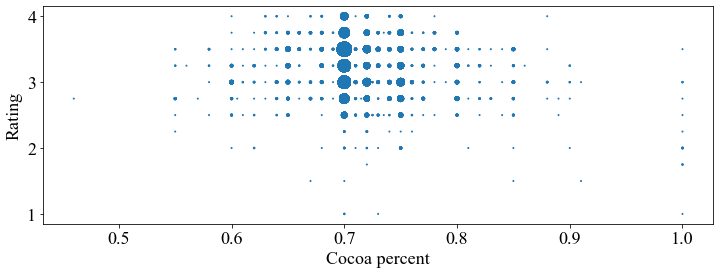

In [600]:
c = Counter(zip(x, y_train))
s = [c[(n, r)] for n, r in zip(x, y_train)]

plt.subplots(figsize=(12, 4))
plt.scatter(x, y_train, marker="o", s=s)
plt.xlabel("Cocoa percent")
plt.ylabel("Rating")
plt.savefig("figures/rating_vs_cocoa_percent.pdf", bbox_inches="tight")
plt.show()

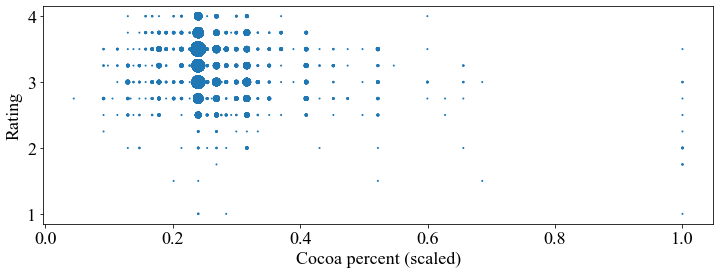

In [607]:
x_scaled = x**4
c = Counter(zip(x_scaled, y_train))
s = [c[(n, r)] for n, r in zip(x_scaled, y_train)]

plt.subplots(figsize=(12, 4))
plt.scatter(x_scaled, y_train, marker="o", s=s)
plt.xlabel("Cocoa percent (scaled)")
plt.ylabel("Rating")
#plt.savefig("figures/rating_vs_cocoa_percent.pdf", bbox_inches="tight")
plt.show()

# Benchmark Models

In [163]:
class simple_median_model:
    median = None
    
    def fit(self, X=None, y=None):
        self.median = y.median()
    
    def predict(self, X):
        return(np.repeat(self.median, X.shape[0]))

In [164]:
median_model = simple_median_model()
median_model.fit(y=y_train)
print_scores(median_model, X_train, X_test)

MSE:		 Train: 0.1967 	Test: 0.1992
MdAE:		 Train: 0.2500 	Test: 0.2500
Accuracy:	 Train: 0.1825 	Test: 0.1825


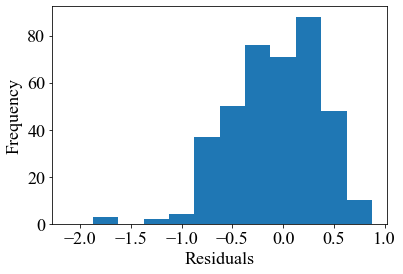

In [194]:
histogram_residuals(y_test, median_model.predict(X_test), "simple_median_model")

In [152]:
baseline_predictors = ["review_date", "cocoa_percent", "number_ingredients"]

In [160]:
X_train_bl = X_train.loc[:, baseline_predictors]
X_test_bl = X_test.loc[:, baseline_predictors]

In [161]:
bl = LinearRegression()
bl.fit(X_train_bl, y_train)
print_scores(bl, X_train_bl, X_test_bl)

MSE:		 Train: 0.1874 	Test: 0.1867
MdAE:		 Train: 0.2909 	Test: 0.2969
Accuracy:	 Train: 0.2017 	Test: 0.2185


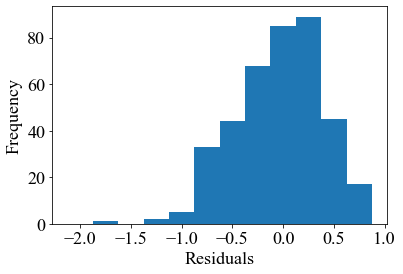

In [195]:
histogram_residuals(y_test, bl.predict(X_test_bl), "linear_regression")

# Processed data

In [220]:
data_proc_ingr["ingredients_raw"] = data_proc_ingr["ingredients"]
data_proc_ingr = pd.get_dummies(data_proc_ingr, prefix=["ingr"], columns=["ingredients"], dummy_na=True, drop_first=False)

In [221]:
data_processed = data_proc_ingr.loc[
    :,
    ~data_proc_ingr.columns.isin(
        [
            "ref",
            "review_date",
            "company_manufacturer",
            "company_location",
            "country_of_bean_origin",
            "specific_bean_origin_or_bar_name",
            "ingredients_raw",
            "most_memorable_characteristics",
            "rating",
        ]
    ),
].copy()
data_processed = (
    data_processed.join(review_date_encoded).join(manufacturer_dummies).join(location_dummies).join(origin_dummies)
)
data_processed.loc[:, "cocoa_percent"] = cocoa_percent / 100
data_processed = data_processed.join(flavours_pca).join(ingredients_df)
data_processed

,cocoa_percent,no_ingredients,ingr_1- B,"ingr_2- B,C","ingr_2- B,S","ingr_2- B,S*","ingr_3- B,S*,C","ingr_3- B,S*,Sa","ingr_3- B,S,C","ingr_3- B,S,L",...,flavour247,flavour248,flavour249,flavour250,sugar,sweetener,cocoa_butter,vanilla,lecithin,salt
0,0.76,3.0,0,0,0,0,0,0,1,0,...,0.000136,-0.000071,-0.000445,0.000279,1,0,1,0,0,0
1,0.76,3.0,0,0,0,0,0,0,1,0,...,0.014052,-0.000223,0.001513,-0.005418,1,0,1,0,0,0
2,0.76,3.0,0,0,0,0,0,0,1,0,...,-0.000580,0.000715,0.000183,-0.002944,1,0,1,0,0,0
3,0.68,3.0,0,0,0,0,0,0,1,0,...,-0.003138,0.002196,-0.001696,-0.001491,1,0,1,0,0,0
4,0.68,3.0,0,0,0,0,0,0,1,0,...,-0.003731,-0.006549,-0.003270,-0.008191,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2583,0.80,4.0,0,0,0,0,0,0,0,0,...,0.006561,-0.005125,0.005653,-0.000034,0,1,1,0,0,1
2584,0.75,3.0,0,0,0,0,0,0,1,0,...,0.001563,0.002472,0.000938,0.000715,1,0,1,0,0,0
2585,0.75,3.0,0,0,0,0,0,0,1,0,...,-0.000133,-0.000572,-0.000104,0.000664,1,0,1,0,0,0
2586,0.70,3.0,0,0,0,0,0,0,1,0,...,0.000157,-0.000910,0.000760,0.001327,1,0,1,0,0,0


In [222]:
print(list(data_processed.columns))

['cocoa_percent', 'no_ingredients', 'ingr_1- B', 'ingr_2- B,C', 'ingr_2- B,S', 'ingr_2- B,S*', 'ingr_3- B,S*,C', 'ingr_3- B,S*,Sa', 'ingr_3- B,S,C', 'ingr_3- B,S,L', 'ingr_3- B,S,V', 'ingr_4- B,S*,C,L', 'ingr_4- B,S*,C,Sa', 'ingr_4- B,S*,C,V', 'ingr_4- B,S*,V,L', 'ingr_4- B,S,C,L', 'ingr_4- B,S,C,Sa', 'ingr_4- B,S,C,V', 'ingr_4- B,S,V,L', 'ingr_5- B,S,C,L,Sa', 'ingr_5- B,S,C,V,L', 'ingr_5-B,S,C,V,Sa', 'ingr_6-B,S,C,V,L,Sa', 'ingr_nan', 'review_date', 'manufac_Soma', 'manufac_Fresco', 'manufac_Arete', 'manufac_Bonnat', 'manufac_A. Morin', 'loc_U.S.A.', 'loc_France', 'loc_Canada', 'loc_U.K.', 'loc_Italy', 'loc_Belgium', 'loc_Ecuador', 'loc_Australia', 'org_Venezuela', 'org_Peru', 'org_Dominican Republic', 'org_Ecuador', 'org_Madagascar', 'org_Blend', 'org_Nicaragua', 'org_Brazil', 'org_Colombia', 'org_Tanzania', 'org_Bolivia', 'org_Belize', 'org_Vietnam', 'org_Guatemala', 'org_Mexico', 'flavour1', 'flavour2', 'flavour3', 'flavour4', 'flavour5', 'flavour6', 'flavour7', 'flavour8', 'flavou

In [223]:
# fill nan no_ingredients with mean depending on cocoa_percent
#for i in np.arange(0.4, 1.1, 0.1):
#    print("[" + str(i) + ", " + str(i + 0.1) + ")")

#    mean = data_processed.loc[
#        ~(data_processed["no_ingredients"].isnull())
#        & (data_processed["cocoa_percent"] < i + 0.1)
#        & (data_processed["cocoa_percent"] >= i),
#        "no_ingredients",
#    ].mean()
#    print(mean)

#    data_processed.loc[
#        (data_processed["no_ingredients"].isnull())
#        & (data_processed["cocoa_percent"] < i + 0.1)
#        & (data_processed["cocoa_percent"] >= i),
#        "no_ingredients",
#    ] = mean
#    print()

### Train/Test Split

In [224]:
from sklearn.model_selection import train_test_split

In [225]:
X_train, X_test, y_train, y_test = train_test_split(data_processed, data["rating"], test_size=0.2, random_state=42)
y_train_cat = y_train.astype(str)
y_test_cat = y_test.astype(str)

In [226]:
#X_train_numeric = X_train.select_dtypes(exclude="object")
#X_test_numeric = X_test.select_dtypes(exclude="object")

## Further Processing and Encoding

### Encoding

In [227]:
from category_encoders import BinaryEncoder, HelmertEncoder

In [50]:
encode_cols = ["company_location", "country_of_bean_origin", "ingredients_raw"]

In [51]:
encoder = HelmertEncoder(cols=encode_cols, drop_invariant=True)
data_encoded = encoder.fit_transform(X_train[encode_cols])
data_encoded.corrwith(y_train)

KeyError: "None of [Index(['company_location', 'country_of_bean_origin', 'ingredients_raw'], dtype='object')] are in the [columns]"

In [ ]:
encoder = BinaryEncoder(cols=encode_cols)
data_encoded = encoder.fit_transform(X_train[encode_cols])
data_encoded.corrwith(y_train)

In [ ]:
X_train

In [ ]:
for col in encode_cols:
    fe = X_train.groupby(col).size()/len(X_train)
    data_encoded.loc[:,col + "_freq_enc"] = X_train[col].map(fe)
    print(col, ": \t", data_encoded[col + "_freq_enc"].corr(y_train))

### Ingredients

In [228]:
# fill nan no_ingredients with mean
mean = X_train.loc[
        ~(X_train["no_ingredients"].isnull()),
        "no_ingredients",
    ].mean()
print(mean)

X_train.loc[
    X_train["no_ingredients"].isnull(),
    "no_ingredients",
] = mean
X_test.loc[
    X_test["no_ingredients"].isnull(),
    "no_ingredients",
] = mean

3.0148809523809526


## Correlations

In [229]:
import seaborn as sns

In [230]:
pd.DataFrame(cocoa_percent).join(data_processed.loc[:, ["review_date", "no_ingredients"]]).join(data["rating"]).corr()

,cocoa_percent,review_date,no_ingredients,rating
cocoa_percent,1.000000,0.007029,-0.228771,-0.144569
review_date,0.007029,1.000000,-0.340171,0.118900
no_ingredients,-0.228771,-0.340171,1.000000,-0.059256
rating,-0.144569,0.118900,-0.059256,1.000000


<AxesSubplot:>

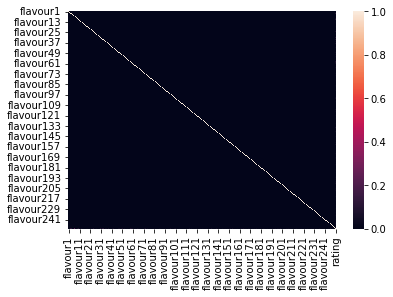

In [231]:
plot_corr = data_processed.loc[:,data_processed.columns.str.startswith("flav")].join(data["rating"]).corr()
sns.heatmap(plot_corr, vmin=0)

In [232]:
pd.set_option('display.max_rows', 78)
data_processed.corrwith(data["rating"])

cocoa_percent    -0.144569
no_ingredients   -0.059256
ingr_1- B        -0.188497
ingr_2- B,C      -0.008782
ingr_2- B,S       0.046533
                    ...   
sweetener        -0.076940
cocoa_butter      0.046211
vanilla          -0.147725
lecithin         -0.051052
salt             -0.046464
Length: 309, dtype: float64

### Scatterplots

#### Review Date

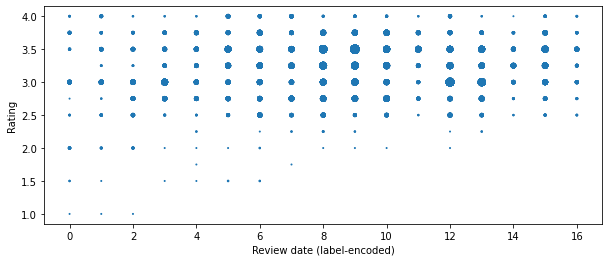

In [287]:
c = Counter(zip(X_train["review_date"], y_train))
s = [c[(n,r)] for n,r in zip(X_train["review_date"], y_train)]

plt.subplots(figsize=(10,4))
plt.scatter(X_train["review_date"], y_train, marker='o', s=s)
plt.xlabel("Review date (label-encoded)")
plt.ylabel("Rating")
plt.savefig("Presentation/review_date.png")
plt.show()

In [234]:
scaler = preprocessing.MinMaxScaler()
review_date_norm_train = scaler.fit_transform(X_train.loc[:, ["review_date"]]).reshape(-1)
review_date_norm_test = scaler.transform(X_test.loc[:, ["review_date"]]).reshape(-1)

X_train["review_date_01"] = review_date_norm_train
X_test["review_date_01"] = review_date_norm_test

In [235]:
print("raw: \t", X_train["review_date_01"].corr(y_train))

for i in np.arange(2,5,1):
    print("^", i, ": \t", (X_train["review_date_01"]**i).corr(y_train))
    
print("exp: \t", X_train["review_date_01"].apply(lambda x: math.exp(x)).corr(y_train))

raw: 	 0.10272970692722698
^ 2 : 	 0.08537886466825112
^ 3 : 	 0.07598692709034569
^ 4 : 	 0.07125172929483586
exp: 	 0.09529189274094543


#### Cocoa Percent

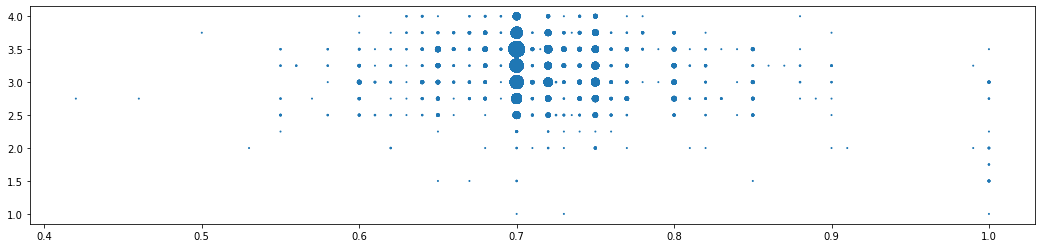

In [236]:
c = Counter(zip(X_train["cocoa_percent"], y_train))
s = [c[(n,r)] for n,r in zip(X_train["cocoa_percent"], y_train)]

plt.figure(figsize=(18,4))
plt.scatter(X_train["cocoa_percent"], y_train, marker='o', s=s)

In [237]:
print("raw: \t", X_train["cocoa_percent"].corr(y_train))

for i in np.arange(2,5,1):
    print("^", i, ": \t", (X_train["cocoa_percent"]**i).corr(y_train))
    
print("exp: \t", X_train["cocoa_percent"].apply(lambda x: math.exp(x)).corr(y_train))
print("log: \t", X_train["cocoa_percent"].apply(lambda x: math.log(x)).corr(y_train))

raw: 	 -0.15468613384454488
^ 2 : 	 -0.17421833595633532
^ 3 : 	 -0.19112448664847756
^ 4 : 	 -0.20511755418418207
exp: 	 -0.16958112954665872
log: 	 -0.13294866479168435


In [238]:
X_train["cocoa_percent_p4"] = X_train["cocoa_percent"]**4
X_test["cocoa_percent_p4"] = X_test["cocoa_percent"]**4

#### Number of Ingredients

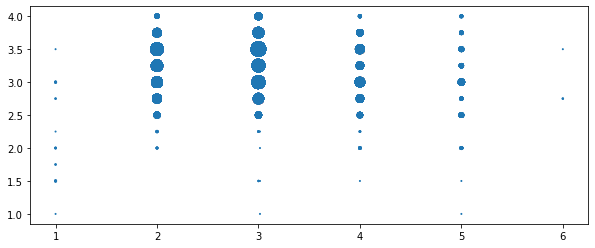

In [239]:
c = Counter(zip(X_train["no_ingredients"], y_train))
s = [c[(n,r)] for n,r in zip(X_train["no_ingredients"], y_train)]

plt.figure(figsize=(10,4))
plt.scatter(X_train["no_ingredients"], y_train, marker='o', s=s)

In [240]:
print("raw: \t", X_train["no_ingredients"].corr(y_train))

for i in np.arange(2,5,1):
    print("^", i, ": \t", (X_train["no_ingredients"]**i).corr(y_train))
    
print("exp: \t", X_train["no_ingredients"].apply(lambda x: math.exp(x)).corr(y_train))
print("log: \t", X_train["no_ingredients"].apply(lambda x: math.log(x)).corr(y_train))

raw: 	 -0.051033273431896405
^ 2 : 	 -0.07686993458664833
^ 3 : 	 -0.09196059014770708
^ 4 : 	 -0.09951207957075418
exp: 	 -0.09744165990994395
log: 	 -0.010776730694139265


In [241]:
X_train["no_ingredients_exp"] = X_train["no_ingredients"].apply(lambda x: math.exp(x))
X_test["no_ingredients_exp"] = X_test["no_ingredients"].apply(lambda x: math.exp(x))

## Lists with groups of variables

In [307]:
baseline_cols = ["review_date", "cocoa_percent"] + data_processed.columns[
    data_processed.columns.str.startswith("ingr_")
].to_list()

raw_numeric_cols = ["review_date", "cocoa_percent"]
scaled_numeric_cols = ["review_date_01", "cocoa_percent_p4"]

ingr_number_col = ["no_ingredients"]
ingr_number_scaled_col = ["no_ingredients_exp"]
ingr_seperated_cols = [
    "sugar",
    "sweetener",
    "cocoa_butter",
    "vanilla",
    "lecithin",
    "salt",
]

ingr_dummy_cols = data_processed.columns[data_processed.columns.str.startswith("ingr_")].to_list()
manufac_dummy_cols = manufacturer_dummies.columns.to_list()
location_dummy_cols = location_dummies.columns.to_list()
origin_dummy_cols = origin_dummies.columns.to_list()
flavour_emb_cols = data_processed.columns[data_processed.columns.str.startswith("flav")].to_list()
flavour_emb_pca95_cols = flavour_emb_cols[0:67]
flavour_emb_pca80_cols = flavour_emb_cols[0:22]

# Baseline Models

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [183]:
X_train_bl = X_train.loc[:, baseline_cols]
X_test_bl = X_test.loc[:, baseline_cols]

In [184]:
bl = LinearRegression()
bl.fit(X_train_bl, y_train)
print_scores(bl, X_train_bl, X_test_bl)

R^2:		 Train: 0.1030 , Valid: 0.0691
MSE:				 Valid: 0.1838
Accuracy:	 Train: 0.2005 , Valid: 0.2490


In [299]:
dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train_bl, y_train_cat)
y_pred_dtc = dtc.predict(X_test_bl)
print_scores_classification(dtc, X_train_bl, X_test_bl)

Accuracy:	 Train: 0.2966 , Valid: 0.2201


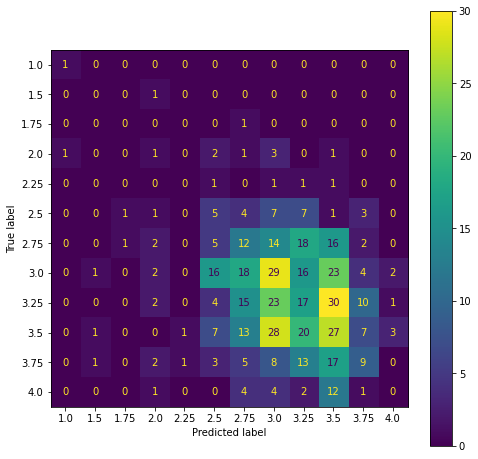

In [182]:
cm = confusion_matrix(y_test_cat, y_pred_dtc)
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(cm, display_labels=dtc.classes_)
disp.plot(ax=ax)
plt.show()

# Linear Regression

## Stepwise add features

In [328]:
def lr_dtc(cols):
    X_train_ = X_train.loc[:, cols]
    X_test_ = X_test.loc[:, cols]
    
    print("Linear Regression:")
    lr_ = LinearRegression()
    lr_.fit(X_train_, y_train)
    print_scores(lr_, X_train_, X_test_)
    
    print("\nDecision Tree Classifier:")
    dtc_ = DecisionTreeClassifier(max_depth=5)
    dtc_.fit(X_train_, y_train_cat)
    y_pred_dtc_ = dtc_.predict(X_test_)
    print_scores_classification(dtc_, X_train_, X_test_)

In [319]:
cols = baseline_cols.copy()
lr_dtc(cols)

Linear Regression:
R^2:		 Train: 0.1030 , Valid: 0.0691
MSE:				 Valid: 0.1838
Accuracy:	 Train: 0.2005 , Valid: 0.2490

Decision Tree Classifier:
Accuracy:	 Train: 0.2966 , Valid: 0.2201


In [321]:
cols = baseline_cols + location_dummy_cols + manufac_dummy_cols + origin_dummy_cols
lr_dtc(cols)

Linear Regression:
R^2:		 Train: 0.1514 , Valid: 0.0915
MSE:				 Valid: 0.1794
Accuracy:	 Train: 0.2155 , Valid: 0.2510

Decision Tree Classifier:
Accuracy:	 Train: 0.3048 , Valid: 0.2162


In [326]:
cols = raw_numeric_cols + ingr_number_col + ingr_seperated_cols
lr_dtc(cols)

Linear Regression:
R^2:		 Train: 0.0937 , Valid: 0.0534
MSE:				 Valid: 0.1869
Accuracy:	 Train: 0.2039 , Valid: 0.2375

Decision Tree Classifier:
Accuracy:	 Train: 0.2976 , Valid: 0.2181


In [330]:
cols = baseline_cols + flavour_emb_pca80_cols
lr_dtc(cols)

Linear Regression:
R^2:		 Train: 0.3663 , Valid: 0.3023
MSE:				 Valid: 0.1377
Accuracy:	 Train: 0.2739 , Valid: 0.2857

Decision Tree Classifier:
Accuracy:	 Train: 0.3420 , Valid: 0.2548


In [331]:
cols = scaled_numeric_cols + ingr_number_scaled_col + ingr_dummy_cols
lr_dtc(cols)

Linear Regression:
R^2:		 Train: 0.1062 , Valid: 0.0737
MSE:				 Valid: 0.1829
Accuracy:	 Train: 0.2019 , Valid: 0.2452

Decision Tree Classifier:
Accuracy:	 Train: 0.2966 , Valid: 0.2201


## Full model

In [332]:
import statsmodels.api as sm

In [339]:
regressors_lr = (
    scaled_numeric_cols
    + ingr_number_scaled_col
    + ingr_seperated_cols
    + manufac_dummy_cols
    + location_dummy_cols
    + origin_dummy_cols
    + flavour_emb_pca80_cols
)
print(regressors_lr)

['review_date_01', 'cocoa_percent_p4', 'no_ingredients_exp', 'sugar', 'sweetener', 'cocoa_butter', 'vanilla', 'lecithin', 'salt', 'manufac_Soma', 'manufac_Fresco', 'manufac_Arete', 'manufac_Bonnat', 'manufac_A. Morin', 'loc_U.S.A.', 'loc_France', 'loc_Canada', 'loc_U.K.', 'loc_Italy', 'loc_Belgium', 'loc_Ecuador', 'loc_Australia', 'org_Venezuela', 'org_Peru', 'org_Dominican Republic', 'org_Ecuador', 'org_Madagascar', 'org_Blend', 'org_Nicaragua', 'org_Brazil', 'org_Colombia', 'org_Tanzania', 'org_Bolivia', 'org_Belize', 'org_Vietnam', 'org_Guatemala', 'org_Mexico', 'flavour1', 'flavour2', 'flavour3', 'flavour4', 'flavour5', 'flavour6', 'flavour7', 'flavour8', 'flavour9', 'flavour10', 'flavour11', 'flavour12', 'flavour13', 'flavour14', 'flavour15', 'flavour16', 'flavour17', 'flavour18', 'flavour19', 'flavour20', 'flavour21', 'flavour22']


In [340]:
X_train_lr = X_train.loc[:, regressors_lr]
X_test_lr = X_test.loc[:, regressors_lr]

In [341]:
lr = LinearRegression()
lr.fit(X_train_lr, y_train)
print_scores(lr, X_train_lr, X_test_lr)

R^2:		 Train: 0.3813 , Valid: 0.2975
MSE:				 Valid: 0.1387
Accuracy:	 Train: 0.2812 , Valid: 0.2703


with scaled_numeric_cols, ingr_seperated_cols, location_dummy_cols (5%), origin_dummy_cols (5%) only: $\newline$
Train R2 =  0.11503917722373813 , Valid R2 =  0.057128032451005284 , Valid MSE =  0.19577608470025032

In [186]:
X = sm.add_constant(X_train_lr)
est = sm.OLS(y_train, X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     21.09
Date:                Wed, 29 Jun 2022   Prob (F-statistic):          5.50e-161
Time:                        09:21:50   Log-Likelihood:                -778.06
No. Observations:                2070   AIC:                             1670.
Df Residuals:                    2013   BIC:                             1991.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

## Backward Elimination

In [187]:
est = sm.OLS(y_train, X).fit()
p = est.pvalues.max()
drop_cols = []

while p > 0.1:
    drop = est.pvalues[est.pvalues==p].index.to_list()
    print("drop:", drop)
    
    drop_cols = drop_cols + drop
    X_reduced = X.loc[:, ~X.columns.isin(drop_cols)]
    est = sm.OLS(y_train, X_reduced).fit()
    
    p = est.pvalues.max()

drop: ['loc_Canada']
drop: ['org_Bolivia']
drop: ['org_Tanzania']
drop: ['flavour18']
drop: ['org_Nicaragua']
drop: ['org_Colombia']
drop: ['loc_France']
drop: ['flavour7']
drop: ['org_Peru']
drop: ['no_ingredients_exp']
drop: ['org_Blend']
drop: ['loc_Italy']
drop: ['org_Vietnam']
drop: ['flavour9']
drop: ['salt']
drop: ['org_Belize']
drop: ['flavour14']
drop: ['flavour11']
drop: ['cocoa_butter']
drop: ['org_Dominican Republic']
drop: ['org_Madagascar']
drop: ['lecithin']
drop: ['org_Guatemala']
drop: ['flavour19']
drop: ['loc_U.K.']


In [188]:
X_train_reduced = X_train_lr.loc[:, ~X_train_lr.columns.isin(drop_cols)]
X_test_reduced = X_test_lr.loc[:, ~X_test_lr.columns.isin(drop_cols)]
print(X_train_reduced.columns)

Index(['review_date_01', 'cocoa_percent_p4', 'sugar', 'sweetener', 'vanilla',
       'manufac_Soma', 'manufac_Fresco', 'manufac_Arete', 'manufac_Bonnat',
       'manufac_A. Morin', 'loc_U.S.A.', 'loc_Belgium', 'loc_Ecuador',
       'loc_Australia', 'org_Venezuela', 'org_Ecuador', 'org_Brazil',
       'org_Mexico', 'flavour1', 'flavour2', 'flavour3', 'flavour4',
       'flavour5', 'flavour6', 'flavour8', 'flavour10', 'flavour12',
       'flavour13', 'flavour15', 'flavour16', 'flavour17'],
      dtype='object')


In [189]:
lr_reduced = LinearRegression()
lr_reduced.fit(X_train_reduced, y_train)
print_scores(lr_reduced, X_train_reduced, X_test_reduced)

R^2:		 Train: 0.3622 , Valid: 0.2668
MSE:				 Valid: 0.1448
Accuracy:	 Train: 0.2763 , Valid: 0.2587


## Lasso

In [342]:
from sklearn.linear_model import Lasso

In [352]:
regressors_clf = (
    scaled_numeric_cols
    + ingr_number_scaled_col
    + ingr_seperated_cols
    + ingr_dummy_cols
    + manufac_dummy_cols
    + location_dummy_cols
    + origin_dummy_cols
    + flavour_emb_pca95_cols
)

In [353]:
X_train_clf = X_train.loc[:, regressors_clf]
X_test_clf = X_test.loc[:, regressors_clf]

In [354]:
clf = Lasso(alpha=0.001)
clf.fit(X_train_clf, y_train)
print_scores(clf, X_train_clf, X_test_clf)

R^2:		 Train: 0.4241 , Valid: 0.3443
MSE:				 Valid: 0.1295
Accuracy:	 Train: 0.2889 , Valid: 0.2934


In [355]:
alphas = np.arange(5e-05, 1e-03, 1e-05)
lasso_score = []
lasso_mse = []

for alpha in alphas:
    clf = Lasso(alpha=alpha)
    clf.fit(X_train_clf, y_train)
    score_ = clf.score(X_test_clf, y_test)
    lasso_score.append(score_)
    mse_ = mse(clf.predict(X_test_clf), y_test)
    lasso_mse.append(mse_)

C:\Users\Ella\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e-01, tolerance: 4.078e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ella\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e-02, tolerance: 4.078e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ella\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

In [356]:
lasso_score_df = pd.DataFrame({"alpha": alphas, "score": lasso_score})
lasso_score_df.loc[lasso_score_df["score"]==lasso_score_df["score"].max(), "alpha"]

1    0.00006
Name: alpha, dtype: float64

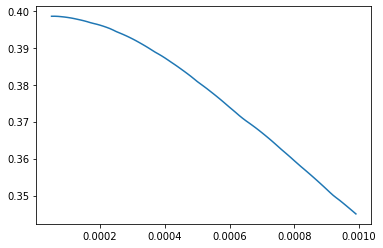

In [357]:
plt.plot(alphas, lasso_score)

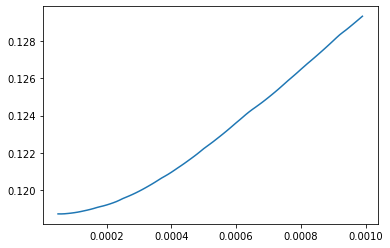

In [358]:
plt.plot(alphas, lasso_mse)

In [360]:
clf = Lasso(alpha=0.00006)
clf.fit(X_train_clf, y_train)
print_scores(clf, X_train_clf, X_test_clf)

R^2:		 Train: 0.5005 , Valid: 0.3985
MSE:				 Valid: 0.1187
Accuracy:	 Train: 0.3425 , Valid: 0.3205


C:\Users\Ella\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e-02, tolerance: 4.078e-02
  model = cd_fast.enet_coordinate_descent(


# Random Forests

In [361]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [367]:
regressors_rf = (
    scaled_numeric_cols
    + ingr_number_scaled_col
    + ingr_seperated_cols
    + ingr_dummy_cols
    + manufac_dummy_cols
    + location_dummy_cols
    + origin_dummy_cols
    + flavour_emb_pca95_cols
)

In [368]:
X_train_rf = X_train.loc[:, regressors_rf]
X_test_rf = X_test.loc[:, regressors_rf]

In [364]:
dt = DecisionTreeRegressor(min_samples_leaf=100)
dt.fit(X_train_rf, y_train)
print_scores(dt, X_train_rf, X_test_rf)

R^2:		 Train: 0.2320 , Valid: 0.0938
MSE:				 Valid: 0.1789
Accuracy:	 Train: 0.2536 , Valid: 0.2336


In [369]:
rf = RandomForestRegressor(min_samples_leaf=50, max_depth=5, random_state=42)
rf.fit(X_train_rf, y_train)
print_scores(rf, X_train_rf, X_test_rf)

R^2:		 Train: 0.3314 , Valid: 0.2135
MSE:				 Valid: 0.1553
Accuracy:	 Train: 0.2493 , Valid: 0.2606


In [201]:
fi_df = pd.DataFrame(
    data={'Feature': X_train_rf.columns, 'Feature importance': rf.feature_importances_}, 
    columns = ['Feature', 'Feature importance']
)
fi_df.sort_values('Feature importance', inplace=True, ascending=False)

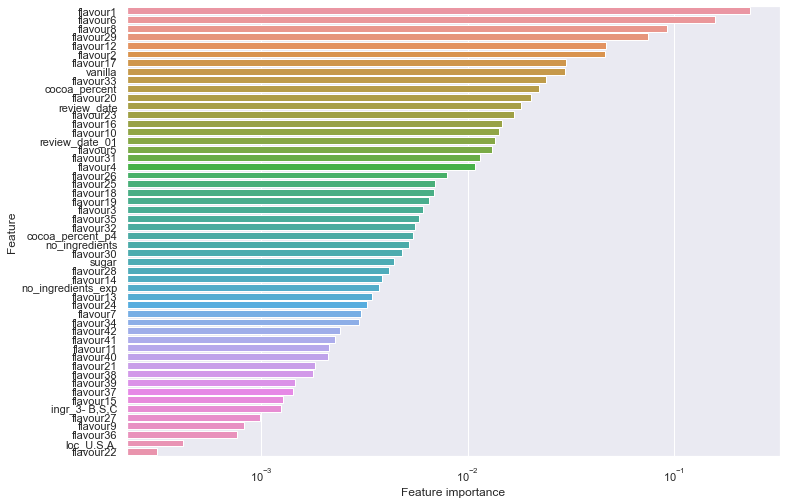

In [202]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=fi_df[fi_df["Feature importance"] > 0], x='Feature importance', y='Feature')
plt.xscale('log')

In [203]:
per_imp = permutation_importance(rf, X_train_rf, y_train, n_repeats=1, n_jobs=-1)
pi_df = pd.DataFrame(
    data={'Feature': X_train_rf.columns, 'Permutation importance': per_imp["importances_mean"]}, 
    columns = ['Feature', 'Permutation importance']
)
pi_df.sort_values('Permutation importance', inplace=True, ascending=False)

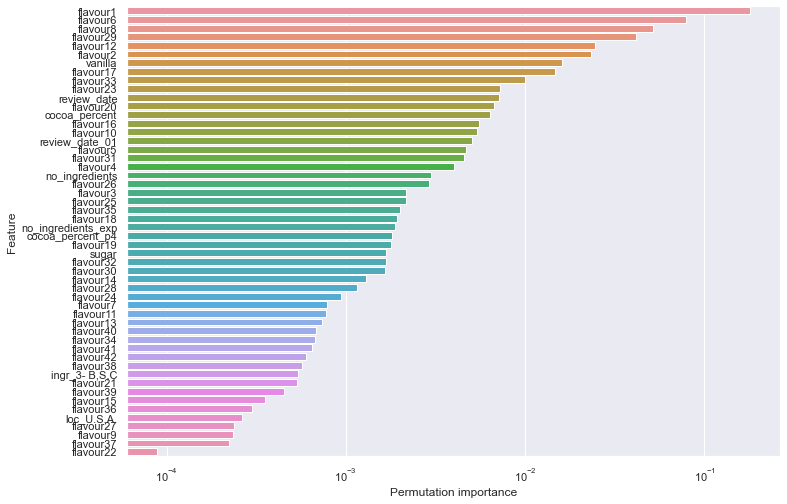

In [204]:
sns.barplot(data=pi_df[pi_df["Permutation importance"] > 0], x='Permutation importance', y='Feature')
plt.xscale('log')

In [205]:
regressors_lr_fi = list(
    set(fi_df[fi_df["Feature importance"] > 0].Feature).intersection(
        pi_df[pi_df["Permutation importance"] > 0].Feature
    )
)
regressors_lr_fi

['flavour3',
 'flavour21',
 'cocoa_percent',
 'flavour23',
 'flavour2',
 'flavour40',
 'flavour13',
 'loc_U.S.A.',
 'ingr_3- B,S,C',
 'review_date_01',
 'flavour38',
 'review_date',
 'flavour12',
 'flavour42',
 'flavour31',
 'flavour15',
 'flavour18',
 'flavour36',
 'no_ingredients_exp',
 'flavour41',
 'flavour27',
 'flavour33',
 'flavour8',
 'flavour26',
 'flavour29',
 'flavour19',
 'flavour4',
 'flavour24',
 'sugar',
 'flavour14',
 'flavour10',
 'flavour5',
 'vanilla',
 'cocoa_percent_p4',
 'flavour39',
 'flavour37',
 'flavour22',
 'flavour32',
 'flavour25',
 'flavour16',
 'flavour7',
 'flavour9',
 'flavour6',
 'flavour11',
 'flavour20',
 'flavour30',
 'flavour1',
 'flavour28',
 'flavour17',
 'no_ingredients',
 'flavour34',
 'flavour35']

In [206]:
# repeat linear regression with features selected by importance in random forest
X_train_lr_fi = X_train.loc[:, regressors_lr_fi]
X_test_lr_fi = X_test.loc[:, regressors_lr_fi]

lr_reduced = LinearRegression()
lr_reduced.fit(X_train_lr_fi, y_train)
print_scores(lr_reduced, X_train_lr_fi, X_test_lr_fi)

R^2:		 Train: 0.4302 , Valid: 0.3663
MSE:				 Valid: 0.1251
Accuracy:	 Train: 0.3005 , Valid: 0.2915
